# Weber Fractions and JNDs Analysis: Cross-Modal Temporal Discrimination

This notebook analyzes Weber fractions and Just Noticeable Differences (JNDs) for the **cross-modal** duration discrimination task where one interval is auditory (test) and the other is visual (standard).

## Overview
- **Standard**: Visual stimulus, ~500ms (always visual)
- **Test**: Auditory stimulus with varying duration
- **Auditory high reliability**: Low noise (0.1)
- **Auditory low reliability**: High noise (1.2)
- **Key difference from unimodal**: μ is FREE because the PSE reflects cross-modal temporal bias

## PSE / μ Interpretation in Cross-Modal Task
In the **unimodal** task, both intervals are the same modality, so μ = 0 is a reasonable assumption (no systematic bias).  
In the **cross-modal** task, one interval is visual and the other auditory. Auditory stimuli are often perceived as longer than visual stimuli of the same physical duration. Therefore:
- **μ must be free** — it captures the cross-modal temporal bias
- **PSE = standard_dur × exp(μ)** — the auditory test duration perceived as equal to the 500ms visual standard
- **PSE shift = standard_dur × (exp(μ) − 1)** — positive means auditory perceived as longer (test must be shorter to match)
- The **same log-normal conversion formulas** apply for σ → JND, Weber fraction, etc.

## 1. Import Libraries and Setup

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')

# Set style for publication-quality figures
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("✓ Libraries imported successfully")

# Set global parameters
STANDARD_DURATION = 0.5  # 500ms visual standard duration
FONT_SIZE = 14
TITLE_SIZE = 16

✓ Libraries imported successfully


## 2. Load Per-Participant Fits and Compute Weber Fractions / JNDs

Since this is cross-modal, we **always use free μ** (FIXED_MU = False).
The per-participant fits will be done in this notebook if .mat files don't exist yet.

In [2]:
# ============================================================================
# RE-FIT ALL PARTICIPANTS: LOG-NORMAL model for CROSS-MODAL task
# Model: P(choose auditory test) = λ/2 + (1-λ) * Φ((log(test/standard) - μ) / σ)
# μ is FREE because cross-modal bias is expected
# ============================================================================

import numpy as np, pandas as pd, scipy.io, os
from scipy.stats import norm, wilcoxon, friedmanchisquare
from scipy.optimize import minimize
from tqdm import tqdm

# ====================== CONFIGURATION ======================
FIXED_MU = False          # MUST be False for cross-modal (PSE bias expected)
MIN_TEST_DUR_S = 0        # Filter threshold (0 = no filter)
SIGMA_CUTOFF = 10         # Exclude participants with any σ > this value
# ============================================================

_mu_str = "freeMu"  # always free for cross-modal
_filt_str = "_filtered" if MIN_TEST_DUR_S > 0 else ""
FIT_SUFFIX = f"_fits_logNormal_{_mu_str}{_filt_str}"
SAVE_SUFFIX = FIT_SUFFIX

print(f"FIXED_MU = {FIXED_MU}  |  MIN_TEST_DUR_S = {MIN_TEST_DUR_S}")
print(f"Fit/Save suffix: {FIT_SUFFIX}")
print("="*80)

# --- psychometric function ---
def psychometric_lognormal(test_dur, standard_dur, lambda_, mu, sigma):
    z = (np.log(test_dur / standard_dur) - mu) / sigma
    return lambda_/2 + (1 - lambda_) * norm.cdf(z)

# --- NLL: joint cross-modal (two noise levels, shared lambda, free mu per noise) ---
def nll_joint_crossmodal(params, test_durs, standard_durs, chose_test, total_resp,
                          noise_levels, unique_noise):
    n_noise = len(unique_noise)
    lambda_ = params[0]
    sigmas  = params[1:1+n_noise]
    mus     = params[1+n_noise:1+2*n_noise]  # always free for cross-modal

    nll = 0.0
    for i in range(len(test_durs)):
        nidx  = np.where(unique_noise == noise_levels.iloc[i])[0][0]
        p = psychometric_lognormal(test_durs.iloc[i], standard_durs.iloc[i],
                                   lambda_, mus[nidx], sigmas[nidx])
        p = np.clip(p, 1e-10, 1 - 1e-10)
        nll -= chose_test.iloc[i]*np.log(p) + (total_resp.iloc[i]-chose_test.iloc[i])*np.log(1-p)
    return nll

def fit_participant_crossmodal(data, unique_noise):
    """Fit cross-modal log-normal model with free mu per noise level."""
    n_noise = len(unique_noise)
    grouped = data.groupby(['testDurS', 'audNoise', 'standardDur']).agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('responses', 'count')).reset_index()

    best_result, best_nll = None, np.inf
    for lam_init in [0.02, 0.05, 0.2]:
        for sig_init in [0.01, 0.1, 0.3, 0.5]:
            for mu_init in [-0.3, -0.1, 0.0, 0.1, 0.3]:
                x0 = [lam_init] + [sig_init]*n_noise + [mu_init]*n_noise
                bounds = [(0, 0.5)] + [(0.01, 3.5)]*n_noise + [(-1.5, 1.5)]*n_noise
                try:
                    r = minimize(nll_joint_crossmodal, x0=x0,
                                 args=(grouped['testDurS'], grouped['standardDur'],
                                       grouped['chose_test'], grouped['total_responses'],
                                       grouped['audNoise'], unique_noise),
                                 bounds=bounds, method='L-BFGS-B')
                    if r.fun < best_nll: best_nll, best_result = r.fun, r
                except: pass
    return best_result

# ============================================================================
# LOAD DATA AND FIT
# ============================================================================
crossmodal_data = pd.read_csv("data/all_crossModal.csv")
crossmodal_data = crossmodal_data[(crossmodal_data['audNoise'] != 0) & (crossmodal_data['standardDur'] != 0)]
crossmodal_data = crossmodal_data.round({'audNoise': 2, 'delta_dur_percents': 2})
crossmodal_data['chose_test'] = (crossmodal_data['responses'] == crossmodal_data['order']).astype(int)

participant_ids = sorted(crossmodal_data['participantID'].unique())
print(f"Participants found: {participant_ids}")

# Per-participant fitting
refit_results = {}
sigma_high_list, sigma_low_list = [], []
mu_high_list, mu_low_list = [], []
lambda_list = []
valid_participants = []

for pid in tqdm(participant_ids, desc="Fitting cross-modal"):
    if pid in ["LN"]:
        print(f"  {pid}: Skipping (known outlier)"); continue
    try:
        pdf = crossmodal_data[crossmodal_data['participantID'] == pid].copy()
        if MIN_TEST_DUR_S > 0:
            pdf = pdf[pdf['testDurS'] >= MIN_TEST_DUR_S]
        unique_noise = np.sort(pdf['audNoise'].unique())
        n_noise = len(unique_noise)
        if n_noise < 2:
            print(f"  {pid}: Only {n_noise} noise level(s), skipping"); continue

        fit = fit_participant_crossmodal(pdf, unique_noise)
        if fit is None:
            print(f"  {pid}: Fit failed"); continue

        params = fit.x  # [lambda, sigma_high, sigma_low, mu_high, mu_low]
        # unique_noise is sorted: [0.1, 1.2]
        # index 0 → noise=0.1 (high reliability), index 1 → noise=1.2 (low reliability)
        lambda_list.append(params[0])
        sigma_high_list.append(params[1])  # noise=0.1
        sigma_low_list.append(params[2])   # noise=1.2
        mu_high_list.append(params[3])     # noise=0.1
        mu_low_list.append(params[4])      # noise=1.2
        valid_participants.append(pid)

        # Save .mat file
        save_arr = params  # [lam, sig1, sig2, mu1, mu2]
        scipy.io.savemat(f"data/{pid.lower()}_crossmodal{SAVE_SUFFIX}.mat",
                       {'fittedParams': save_arr, 'unique_noise': unique_noise,
                        'n_trials': len(pdf), 'fixed_mu': 0})

        print(f"  {pid}: λ={params[0]:.3f}  σ_high={params[1]:.4f} σ_low={params[2]:.4f}  "
              f"μ_high={params[3]:.4f} μ_low={params[4]:.4f}")
    except Exception as e:
        print(f"  {pid}: ERROR - {e}")

sigma_cm_high = np.array(sigma_high_list)
sigma_cm_low  = np.array(sigma_low_list)
mu_cm_high    = np.array(mu_high_list)
mu_cm_low     = np.array(mu_low_list)

# Exclude extreme σ
keep_mask = (sigma_cm_high <= SIGMA_CUTOFF) & (sigma_cm_low <= SIGMA_CUTOFF)
excluded = [pid for pid, k in zip(valid_participants, keep_mask) if not k]
if excluded:
    print(f"\nExcluded {len(excluded)} participant(s) with σ > {SIGMA_CUTOFF}: {excluded}")

sigma_cm_high = sigma_cm_high[keep_mask]
sigma_cm_low  = sigma_cm_low[keep_mask]
mu_cm_high    = mu_cm_high[keep_mask]
mu_cm_low     = mu_cm_low[keep_mask]
valid_participants = [pid for pid, k in zip(valid_participants, keep_mask) if k]
n_participants = len(valid_participants)

print(f"\n{'='*65}")
print(f"Loaded {n_participants} participants: {valid_participants}")
print(f"{'='*65}")

FIXED_MU = False  |  MIN_TEST_DUR_S = 0
Fit/Save suffix: _fits_logNormal_freeMu
Participants found: ['DT', 'HH', 'IP', 'LN', 'as', 'ln', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']


Fitting cross-modal:   8%|▊         | 1/12 [00:35<06:35, 35.92s/it]

  DT: λ=0.088  σ_high=1.0624 σ_low=0.8635  μ_high=0.0248 μ_low=0.2546


Fitting cross-modal:  17%|█▋        | 2/12 [01:26<07:28, 44.80s/it]

  HH: λ=0.207  σ_high=0.2261 σ_low=0.5391  μ_high=-0.2936 μ_low=0.0774


Fitting cross-modal:  25%|██▌       | 3/12 [02:33<08:12, 54.67s/it]

  IP: λ=0.061  σ_high=0.1109 σ_low=0.7794  μ_high=-0.1715 μ_low=-0.4888


Fitting cross-modal:  33%|███▎      | 4/12 [02:48<05:12, 39.06s/it]

  LN: λ=0.318  σ_high=0.3456 σ_low=0.2617  μ_high=-0.8372 μ_low=-0.7356


Fitting cross-modal:  42%|████▏     | 5/12 [03:21<04:18, 37.00s/it]

  as: λ=0.353  σ_high=0.0547 σ_low=0.5580  μ_high=-0.2608 μ_low=-0.3388


Fitting cross-modal:  50%|█████     | 6/12 [04:30<04:47, 47.91s/it]

  ln: λ=0.302  σ_high=0.2425 σ_low=0.2673  μ_high=-0.0730 μ_low=-0.4422


Fitting cross-modal:  58%|█████▊    | 7/12 [05:04<03:36, 43.35s/it]

  mh: λ=0.078  σ_high=0.4879 σ_low=0.6499  μ_high=-0.2667 μ_low=-0.0128


Fitting cross-modal:  67%|██████▋   | 8/12 [05:37<02:39, 39.89s/it]

  ml: λ=0.056  σ_high=0.4346 σ_low=0.4673  μ_high=-0.3195 μ_low=-0.0734


Fitting cross-modal:  75%|███████▌  | 9/12 [06:12<01:55, 38.44s/it]

  mt: λ=0.271  σ_high=0.1919 σ_low=0.4920  μ_high=-0.3013 μ_low=-0.1640


Fitting cross-modal:  83%|████████▎ | 10/12 [07:20<01:35, 47.58s/it]

  oy: λ=0.418  σ_high=0.2697 σ_low=0.1077  μ_high=-0.4333 μ_low=-0.2122


Fitting cross-modal:  92%|█████████▏| 11/12 [07:49<00:41, 41.79s/it]

  qs: λ=0.135  σ_high=0.2644 σ_low=0.5389  μ_high=-0.1426 μ_low=-0.1536


Fitting cross-modal: 100%|██████████| 12/12 [08:21<00:00, 41.80s/it]

  sx: λ=0.156  σ_high=0.2750 σ_low=0.2830  μ_high=0.1679 μ_low=0.1727

Loaded 12 participants: ['DT', 'HH', 'IP', 'LN', 'as', 'ln', 'mh', 'ml', 'mt', 'oy', 'qs', 'sx']


In [3]:
# ============================================================================
# CONVERSION FUNCTIONS (same as unimodal, but μ is always free here)
# ============================================================================
# Log-normal model: P(choose test) = λ/2 + (1-λ) * Φ((log(T_test/T_std) - μ) / σ)
#
# When μ free (cross-modal):
#   PSE       = T_std × exp(μ)
#   PSE shift = T_std × (exp(μ) − 1)       [positive → auditory perceived longer]
#   SD        = T_std × √[(exp(σ²) − 1) × exp(2μ + σ²)]
#   JND 75%   = T_std × exp(μ) × (exp(0.6745·σ) − 1)
#   Weber     = √(exp(σ²) − 1)              [depends only on σ]
#
# NOTE ON μ CONVERSION:
# The μ parameter lives in log-ratio space: log(T_test / T_std).
# Since both unimodal and cross-modal use the same formula with T_std = 500ms,
# **no special conversion is needed**. The same exp(μ) mapping gives the PSE.
# What differs is interpretation:
#   - Unimodal μ ≈ 0 (no systematic bias expected)
#   - Cross-modal μ ≠ 0 reflects modality-dependent temporal distortion
# ============================================================================

standard_dur_s = 0.5
z_75 = 0.6745

def log_to_linear_sd_s(sigma_log, mu_log):
    """SD in seconds."""
    var_lin = np.exp(2*mu_log + sigma_log**2) * (np.exp(sigma_log**2) - 1)
    return np.sqrt(var_lin) * standard_dur_s

def log_to_weber(sigma_log):
    """Weber fraction (CV): √(exp(σ²) − 1). Depends only on σ."""
    return np.sqrt(np.exp(sigma_log**2) - 1)

def log_to_jnd_s(sigma_log, mu_log):
    """JND at 75% in seconds."""
    return standard_dur_s * np.exp(mu_log) * (np.exp(z_75 * sigma_log) - 1)

def log_to_pse_shift_s(mu_log):
    """PSE shift in seconds: how much the auditory test differs from 500ms visual standard."""
    return standard_dur_s * (np.exp(mu_log) - 1)

def log_to_pse_s(mu_log):
    """PSE in seconds: auditory test duration perceived equal to visual standard."""
    return standard_dur_s * np.exp(mu_log)

# ============================================================================
# REPORT: PER-PARTICIPANT σ, μ, AND DERIVED MEASURES
# ============================================================================
conditions = [
    ("Cross-modal High Rel (0.1)", sigma_cm_high, mu_cm_high),
    ("Cross-modal Low Rel (1.2)",  sigma_cm_low,  mu_cm_low),
]

print("="*75)
print(" MEDIAN σ AND μ (Cross-Modal: Visual standard, Auditory test)")
print("="*75)
for name, sig, mu in conditions:
    print(f"  {name:<30s}  σ = {np.median(sig):.4f}  (IQR {np.percentile(sig,25):.4f}–{np.percentile(sig,75):.4f})")
    print(f"  {'':30s}  μ = {np.median(mu):.4f}  (IQR {np.percentile(mu,25):.4f}–{np.percentile(mu,75):.4f})")

print("\n" + "="*75)
print(" CONVERTED TO LINEAR SPACE")
print("="*75)
for name, sig, mu in conditions:
    ms  = np.median(sig)
    mm  = np.median(mu)
    sd_s  = log_to_linear_sd_s(ms, mm)
    w     = log_to_weber(ms)
    jnd_s = log_to_jnd_s(ms, mm)
    pse_s = log_to_pse_s(mm)
    pse_shift_s = log_to_pse_shift_s(mm)
    print(f"\n  {name}  (σ={ms:.4f}, μ={mm:.4f}):")
    print(f"    SD        = {sd_s*1000:.1f} ms")
    print(f"    JND 75%   = {jnd_s*1000:.1f} ms")
    print(f"    Weber     = {w:.4f}")
    print(f"    PSE       = {pse_s*1000:.1f} ms  (visual standard = 500 ms)")
    print(f"    PSE shift = {pse_shift_s*1000:+.1f} ms")
    if pse_shift_s > 0:
        print(f"    → Auditory perceived LONGER: test must be {abs(pse_shift_s)*1000:.1f} ms shorter to match")
    elif pse_shift_s < 0:
        print(f"    → Auditory perceived SHORTER: test must be {abs(pse_shift_s)*1000:.1f} ms longer to match")
    else:
        print(f"    → No cross-modal bias")

# Per-person arrays
weber_cm_high  = log_to_weber(sigma_cm_high)
weber_cm_low   = log_to_weber(sigma_cm_low)
jnd_cm_high    = log_to_jnd_s(sigma_cm_high, mu_cm_high) * 1000
jnd_cm_low     = log_to_jnd_s(sigma_cm_low, mu_cm_low) * 1000
pse_cm_high    = log_to_pse_s(mu_cm_high) * 1000
pse_cm_low     = log_to_pse_s(mu_cm_low) * 1000
pse_shift_cm_high = log_to_pse_shift_s(mu_cm_high) * 1000
pse_shift_cm_low  = log_to_pse_shift_s(mu_cm_low) * 1000
standard_dur_ms = 500

# Per-participant table
print("\n" + "="*75)
print(" PER-PARTICIPANT: σ, μ, JND(ms), PSE(ms), PSE shift(ms)")
print("="*75)
header = f"  {'PID':>4}  {'σ':>6}  {'μ':>7}  {'JND(ms)':>8}  {'PSE(ms)':>8}  {'PSEshift':>9}"

for cond_name, sig, mu in conditions:
    print(f"\n  {cond_name}:")
    print(header)
    for i, pid in enumerate(valid_participants):
        jnd_ms = log_to_jnd_s(sig[i], mu[i]) * 1000
        pse_ms = log_to_pse_s(mu[i]) * 1000
        pse_shift_ms = log_to_pse_shift_s(mu[i]) * 1000
        flag = " ⚠" if sig[i] > 0.8 or abs(mu[i]) > 0.5 else ""
        print(f"  {pid:>4}  {sig[i]:>6.3f}  {mu[i]:>7.4f}  {jnd_ms:>8.1f}  {pse_ms:>8.1f}  {pse_shift_ms:>+9.1f}{flag}")

# ============================================================================
# WEBER FRACTIONS — per-participant
# ============================================================================
print("\n" + "="*75)
print(" WEBER FRACTIONS  (WF = √(exp(σ²) − 1))")
print("="*75)

wf_conditions = [
    ("Cross-modal High Rel (0.1)", weber_cm_high),
    ("Cross-modal Low Rel (1.2)",  weber_cm_low),
]
for name, wf in wf_conditions:
    print(f"  {name:<30s}  WF = {np.median(wf):.4f}  "
          f"(IQR {np.percentile(wf,25):.4f}–{np.percentile(wf,75):.4f})  "
          f"mean = {np.mean(wf):.4f}")

print(f"\n  {'PID':>4}  {'WF_cm_hi':>10}  {'WF_cm_lo':>10}")
for i, pid in enumerate(valid_participants):
    print(f"  {pid:>4}  {weber_cm_high[i]:>10.4f}  {weber_cm_low[i]:>10.4f}")

 MEDIAN σ AND μ (Cross-Modal: Visual standard, Auditory test)
  Cross-modal High Rel (0.1)      σ = 0.2670  (IQR 0.2176–0.3679)
                                  μ = -0.2638  (IQR -0.3059–-0.1252)
  Cross-modal Low Rel (1.2)       σ = 0.5154  (IQR 0.2791–0.5809)
                                  μ = -0.1588  (IQR -0.3646–0.0098)

 CONVERTED TO LINEAR SPACE

  Cross-modal High Rel (0.1)  (σ=0.2670, μ=-0.2638):
    SD        = 108.2 ms
    JND 75%   = 75.8 ms
    Weber     = 0.2718
    PSE       = 384.1 ms  (visual standard = 500 ms)
    PSE shift = -115.9 ms
    → Auditory perceived SHORTER: test must be 115.9 ms longer to match

  Cross-modal Low Rel (1.2)  (σ=0.5154, μ=-0.1588):
    SD        = 268.7 ms
    JND 75%   = 177.3 ms
    Weber     = 0.5516
    PSE       = 426.6 ms  (visual standard = 500 ms)
    PSE shift = -73.4 ms
    → Auditory perceived SHORTER: test must be 73.4 ms longer to match

 PER-PARTICIPANT: σ, μ, JND(ms), PSE(ms), PSE shift(ms)

  Cross-modal High Rel (0.1):
 

In [4]:
# ============================================================================
# NON-PARAMETRIC STATISTICAL COMPARISONS (σ and μ)
# ============================================================================
from scipy.stats import wilcoxon

print("NON-PARAMETRIC STATISTICAL TESTS (Cross-Modal)")
print("="*60)
print(f"N = {n_participants} participants")
print()

# --- σ comparison: High Rel vs Low Rel ---
print("1. SIGMA COMPARISON: Cross-modal High Rel vs Low Rel")
print("-"*50)
stat_sig, p_sig = wilcoxon(sigma_cm_high, sigma_cm_low, alternative='two-sided')
diff_sig = sigma_cm_high - sigma_cm_low
print(f"   Median σ_high = {np.median(sigma_cm_high):.4f}, Median σ_low = {np.median(sigma_cm_low):.4f}")
print(f"   Median difference: {np.median(diff_sig):.4f}")
print(f"   W = {stat_sig:.1f}, p = {p_sig:.4f}")
if p_sig < 0.05:
    print("   → Significant difference in discrimination precision")
else:
    print("   → No significant difference")

# --- μ comparison: High Rel vs Low Rel (do biases differ?) ---
print(f"\n2. MU (BIAS) COMPARISON: Cross-modal High Rel vs Low Rel")
print("-"*50)
stat_mu, p_mu = wilcoxon(mu_cm_high, mu_cm_low, alternative='two-sided')
diff_mu = mu_cm_high - mu_cm_low
print(f"   Median μ_high = {np.median(mu_cm_high):.4f}, Median μ_low = {np.median(mu_cm_low):.4f}")
print(f"   Median difference: {np.median(diff_mu):.4f}")
print(f"   W = {stat_mu:.1f}, p = {p_mu:.4f}")
if p_mu < 0.05:
    print("   → Significant: cross-modal bias differs between noise levels")
else:
    print("   → No significant difference in cross-modal bias")

# --- Test whether μ differs from 0 (is there a cross-modal bias at all?) ---
print(f"\n3. TEST WHETHER μ ≠ 0 (cross-modal temporal bias exists)")
print("-"*50)
for name, mu_arr in [("High Rel (0.1)", mu_cm_high), ("Low Rel (1.2)", mu_cm_low)]:
    try:
        stat_zero, p_zero = wilcoxon(mu_arr, alternative='two-sided')
        print(f"   {name}: median μ = {np.median(mu_arr):.4f}, W = {stat_zero:.1f}, p = {p_zero:.4f}")
        pse_shift_med = log_to_pse_shift_s(np.median(mu_arr)) * 1000
        if p_zero < 0.025:  # Bonferroni for 2 tests
            print(f"     → Significant cross-modal bias (PSE shift = {pse_shift_med:+.1f} ms)")
        else:
            print(f"     → No significant bias (PSE shift = {pse_shift_med:+.1f} ms)")
    except Exception as e:
        print(f"   {name}: Could not test - {e}")

# --- PSE shift comparison ---
print(f"\n4. PSE SHIFT SUMMARY")
print("-"*50)
print(f"   High Rel: PSE shift = {np.median(pse_shift_cm_high):+.1f} ms (IQR {np.percentile(pse_shift_cm_high,25):+.1f} to {np.percentile(pse_shift_cm_high,75):+.1f})")
print(f"   Low Rel:  PSE shift = {np.median(pse_shift_cm_low):+.1f} ms (IQR {np.percentile(pse_shift_cm_low,25):+.1f} to {np.percentile(pse_shift_cm_low,75):+.1f})")

NON-PARAMETRIC STATISTICAL TESTS (Cross-Modal)
N = 12 participants

1. SIGMA COMPARISON: Cross-modal High Rel vs Low Rel
--------------------------------------------------
   Median σ_high = 0.2670, Median σ_low = 0.5154
   Median difference: -0.0973
   W = 16.0, p = 0.0771
   → No significant difference

2. MU (BIAS) COMPARISON: Cross-modal High Rel vs Low Rel
--------------------------------------------------
   Median μ_high = -0.2638, Median μ_low = -0.1588
   Median difference: -0.1195
   W = 26.0, p = 0.3394
   → No significant difference in cross-modal bias

3. TEST WHETHER μ ≠ 0 (cross-modal temporal bias exists)
--------------------------------------------------
   High Rel (0.1): median μ = -0.2638, W = 5.0, p = 0.0049
     → Significant cross-modal bias (PSE shift = -115.9 ms)
   Low Rel (1.2): median μ = -0.1588, W = 17.0, p = 0.0923
     → No significant bias (PSE shift = -73.4 ms)

4. PSE SHIFT SUMMARY
--------------------------------------------------
   High Rel: PSE sh

In [5]:
# Effect Size Calculations
from scipy import stats as spstats

def rank_biserial_correlation(x, y):
    diff = x - y
    diff_nonzero = diff[diff != 0]
    n = len(diff_nonzero)
    ranks = spstats.rankdata(np.abs(diff_nonzero))
    R_plus = np.sum(ranks[diff_nonzero > 0])
    R_minus = np.sum(ranks[diff_nonzero < 0])
    r = (R_plus - R_minus) / (R_plus + R_minus)
    return r

def interpret_effect_size(r):
    r_abs = abs(r)
    if r_abs < 0.3: return "small"
    elif r_abs < 0.5: return "medium"
    else: return "large"

def cohens_d_paired(x, y):
    diff = x - y
    return np.mean(diff) / np.std(diff, ddof=1)

print("EFFECT SIZE ANALYSIS (Cross-Modal)")
print("="*60)

# σ effect size
r_sig = rank_biserial_correlation(sigma_cm_high, sigma_cm_low)
d_sig = cohens_d_paired(sigma_cm_high, sigma_cm_low)
print(f"σ: High Rel vs Low Rel")
print(f"   r = {r_sig:.3f} ({interpret_effect_size(r_sig)} effect), Cohen's d = {d_sig:.2f}")

# μ effect size
r_mu = rank_biserial_correlation(mu_cm_high, mu_cm_low)
d_mu = cohens_d_paired(mu_cm_high, mu_cm_low)
print(f"\nμ: High Rel vs Low Rel")
print(f"   r = {r_mu:.3f} ({interpret_effect_size(r_mu)} effect), Cohen's d = {d_mu:.2f}")

EFFECT SIZE ANALYSIS (Cross-Modal)
σ: High Rel vs Low Rel
   r = -0.590 (large effect), Cohen's d = -0.58

μ: High Rel vs Low Rel
   r = -0.333 (medium effect), Cohen's d = -0.29


## 3. Bootstrap Analysis on Pooled Cross-Modal Data (Log-Normal)

In [6]:
# ============================================================================
# BOOTSTRAP ANALYSIS: LOG-NORMAL ON POOLED CROSS-MODAL DATA
# μ is always FREE
# ============================================================================

from scipy import stats
from scipy.optimize import minimize
from tqdm import tqdm

def psychometric_lognormal_boot(test_dur, standard_dur, lambda_, mu, sigma):
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    return lambda_/2 + (1 - lambda_) * stats.norm.cdf(z)

def nll_lognormal_single(params, test_durs, standard_durs, chose_test, total_resp):
    lambda_, mu, sigma = params
    if sigma <= 0 or lambda_ < 0 or lambda_ > 0.5:
        return np.inf
    p = psychometric_lognormal_boot(test_durs, standard_durs, lambda_, mu, sigma)
    p = np.clip(p, 1e-10, 1 - 1e-10)
    return -np.sum(chose_test * np.log(p) + (total_resp - chose_test) * np.log(1 - p))

def fit_lognormal_single(df, standard_dur=0.5):
    if 'testDurS' not in df.columns:
        df = df.copy()
        df['testDurS'] = df['standardDur'] * (1 + df['delta_dur_percents'])
    grouped = df.groupby('testDurS').agg(
        chose_test=('chose_test', 'sum'),
        total_responses=('chose_test', 'count'),
        standard_dur=('standardDur', 'first')
    ).reset_index()
    test_durs = grouped['testDurS'].values
    standard_durs = grouped['standard_dur'].values
    chose_test = grouped['chose_test'].values
    total_responses = grouped['total_responses'].values

    best_result, best_nll = None, np.inf
    for lambda_init in [0.02, 0.05, 0.1]:
        for mu_init in [-0.3, -0.1, 0, 0.1, 0.3]:
            for sigma_init in [0.2, 0.4, 0.6]:
                try:
                    result = minimize(nll_lognormal_single,
                                     x0=[lambda_init, mu_init, sigma_init],
                                     args=(test_durs, standard_durs, chose_test, total_responses),
                                     bounds=[(0, 0.25), (-1.5, 1.5), (0.01, 3.0)],
                                     method='L-BFGS-B')
                    if result.fun < best_nll:
                        best_nll = result.fun
                        best_result = result
                except: pass
    return best_result.x if best_result else np.array([0.05, 0, 0.5])

def bootstrap_fit_lognormal_cm(df, n_bootstrap=500, seed=42):
    np.random.seed(seed)
    participants = df['participantID'].unique()
    boot_lambdas, boot_mus, boot_sigmas = [], [], []
    for i in tqdm(range(n_bootstrap), desc="Bootstrap (Cross-Modal LN)"):
        resampled_pids = np.random.choice(participants, size=len(participants), replace=True)
        resampled_data = pd.concat([df[df['participantID'] == pid] for pid in resampled_pids], ignore_index=True)
        params = fit_lognormal_single(resampled_data)
        boot_lambdas.append(params[0])
        boot_mus.append(params[1])
        boot_sigmas.append(params[2])
    return np.array(boot_lambdas), np.array(boot_mus), np.array(boot_sigmas)

# Load and prepare
print("Loading cross-modal data for bootstrap...")
cm_data = pd.read_csv("data/all_crossModal.csv")
cm_data = cm_data[(cm_data['audNoise'] != 0) & (cm_data['standardDur'] != 0)]
cm_data = cm_data.round({'audNoise': 2, 'delta_dur_percents': 2})
cm_data['chose_test'] = (cm_data['responses'] == cm_data['order']).astype(int)
cm_data['testDurS'] = cm_data['standardDur'] * (1 + cm_data['delta_dur_percents'])

cm_high_rel = cm_data[cm_data['audNoise'] == 0.1]
cm_low_rel  = cm_data[cm_data['audNoise'] == 1.2]

print(f"Cross-modal data: {len(cm_data)} trials, {cm_data['participantID'].nunique()} participants")
print(f"  High Rel (0.1): {len(cm_high_rel)} trials")
print(f"  Low Rel  (1.2): {len(cm_low_rel)} trials")

# Point estimates
params_cm_high = fit_lognormal_single(cm_high_rel)
params_cm_low  = fit_lognormal_single(cm_low_rel)
print(f"\nPoint estimates (pooled):")
print(f"  High Rel: λ={params_cm_high[0]:.4f}, μ={params_cm_high[1]:.4f}, σ={params_cm_high[2]:.4f}")
print(f"  Low Rel:  λ={params_cm_low[0]:.4f}, μ={params_cm_low[1]:.4f}, σ={params_cm_low[2]:.4f}")

# Bootstrap
n_boot_cm = 5  # Set to 500 for final analysis
print(f"\nRunning bootstrap (N={n_boot_cm})...")

boot_lam_cm_hi, boot_mu_cm_hi, boot_sig_cm_hi = bootstrap_fit_lognormal_cm(cm_high_rel, n_bootstrap=n_boot_cm)
boot_lam_cm_lo, boot_mu_cm_lo, boot_sig_cm_lo = bootstrap_fit_lognormal_cm(cm_low_rel, n_bootstrap=n_boot_cm)

# Results
print("\n" + "="*70)
print("BOOTSTRAP RESULTS (Cross-Modal, Log-Normal, 95% CI)")
print("="*70)

for cond_name, params, boot_sig, boot_mu in [
    ("High Rel (0.1)", params_cm_high, boot_sig_cm_hi, boot_mu_cm_hi),
    ("Low Rel (1.2)",  params_cm_low,  boot_sig_cm_lo, boot_mu_cm_lo)]:
    print(f"\n{cond_name}:")
    print(f"  σ = {params[2]:.4f} [95% CI: {np.percentile(boot_sig, 2.5):.4f} - {np.percentile(boot_sig, 97.5):.4f}]")
    print(f"  μ = {params[1]:.4f} [95% CI: {np.percentile(boot_mu, 2.5):.4f} - {np.percentile(boot_mu, 97.5):.4f}]")
    
    pse = standard_dur_s * np.exp(params[1])
    pse_shift = (pse - standard_dur_s) * 1000
    weber = np.sqrt(np.exp(params[2]**2) - 1)
    jnd = standard_dur_s * np.exp(params[1]) * (np.exp(z_75 * params[2]) - 1) * 1000
    print(f"  Weber = {weber:.4f}, JND = {jnd:.1f} ms, PSE = {pse*1000:.1f} ms (shift = {pse_shift:+.1f} ms)")

Loading cross-modal data for bootstrap...
Cross-modal data: 4496 trials, 12 participants
  High Rel (0.1): 2248 trials
  Low Rel  (1.2): 2248 trials

Point estimates (pooled):
  High Rel: λ=0.0819, μ=-0.2479, σ=0.6661
  Low Rel:  λ=0.2500, μ=-0.1674, σ=0.7685

Running bootstrap (N=5)...


Bootstrap (Cross-Modal LN): 100%|██████████| 5/5 [00:01<00:00,  4.81it/s]


BOOTSTRAP RESULTS (Cross-Modal, Log-Normal, 95% CI)

High Rel (0.1):
  σ = 0.6661 [95% CI: 0.4449 - 0.7701]
  μ = -0.2479 [95% CI: -0.3002 - -0.1930]
  Weber = 0.7474, JND = 221.3 ms, PSE = 390.2 ms (shift = -109.8 ms)

Low Rel (1.2):
  σ = 0.7685 [95% CI: 0.5877 - 0.8662]
  μ = -0.1674 [95% CI: -0.3078 - -0.0367]
  Weber = 0.8972, JND = 287.2 ms, PSE = 422.9 ms (shift = -77.1 ms)


## 4. Publication Figure: Psychometric Curves + JND Box Plots

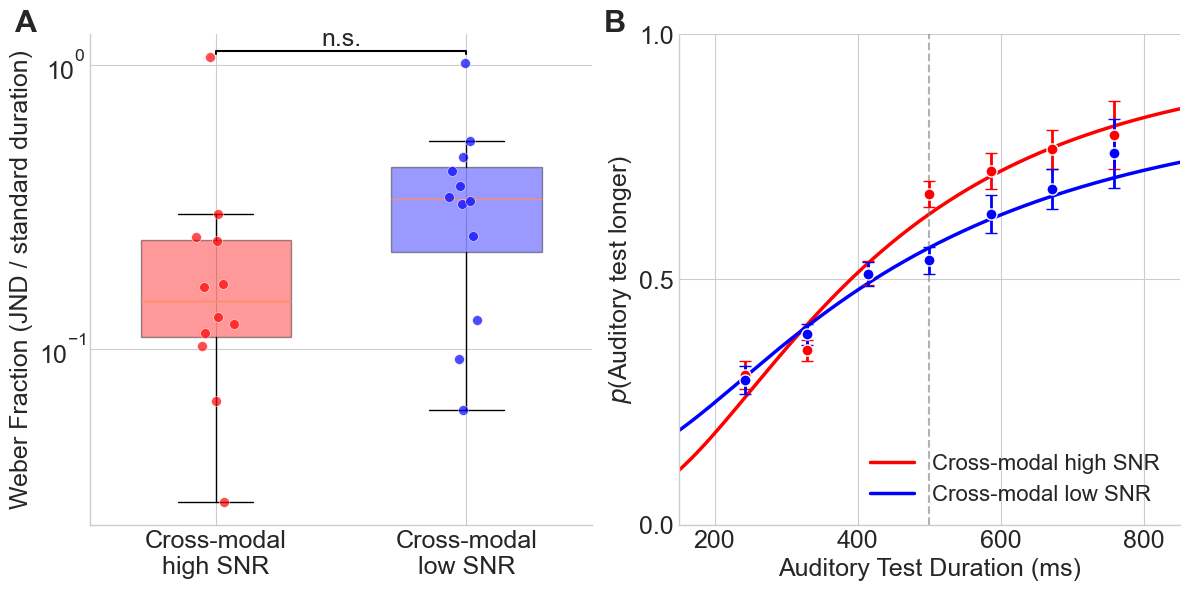

Figure saved as 'psychometric_curves_crossmodal.pdf/.png'

Median Weber fractions: High Rel = 0.2718, Low Rel = 0.5519
Median PSE shifts: High Rel = -115.9 ms, Low Rel = -73.4 ms


In [7]:
# ============================================================================
# PSYCHOMETRIC CURVES + BOX PLOTS: CROSS-MODAL
# ============================================================================

import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

STANDARD_DURATION = 500  # ms
STANDARD_DURATION_S = 0.5
FONT_SIZE = 18

def psychometric_lognormal_plot(test_dur, standard_dur, lambda_, mu, sigma):
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    return lambda_/2 + (1 - lambda_) * stats.norm.cdf(z)

# Cross-modal parameters from pooled fit
lambda_cm = [params_cm_high[0], params_cm_low[0]]
mu_cm     = [params_cm_high[1], params_cm_low[1]]
sigma_cm  = [params_cm_high[2], params_cm_low[2]]

condition_names_cm = ['Cross-modal high SNR', 'Cross-modal low SNR']
colors_cm = ['red', 'blue']

# Binning function
def bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8)):
    df_filtered = df[(df['testDurS'] >= dur_range[0]) & (df['testDurS'] <= dur_range[1])]
    bins = np.linspace(dur_range[0], dur_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    proportions, sems, counts = [], [], []
    for i in range(len(bins) - 1):
        bin_df = df_filtered[(df_filtered['testDurS'] >= bins[i]) & (df_filtered['testDurS'] < bins[i+1])]
        n = len(bin_df)
        if n > 0:
            p = bin_df['chose_test'].mean()
            sem = np.sqrt(p * (1 - p) / n) if n > 1 else 0
        else:
            p, sem = np.nan, np.nan
        proportions.append(p); sems.append(sem); counts.append(n)
    return bin_centers, np.array(proportions), np.array(sems), np.array(counts)

# Prepare data
cm_plot = pd.read_csv("data/all_crossModal.csv")
cm_plot = cm_plot[(cm_plot['audNoise'] != 0) & (cm_plot['standardDur'] != 0)]
cm_plot['chose_test'] = (cm_plot['responses'] == cm_plot['order']).astype(int)
cm_plot['testDurS'] = cm_plot['standardDur'] * (1 + cm_plot['delta_dur_percents'])

cm_hi_plot = cm_plot[cm_plot['audNoise'] == 0.1]
cm_lo_plot = cm_plot[cm_plot['audNoise'] == 1.2]

datasets_cm = [(cm_hi_plot, 'Cross-modal high SNR'), (cm_lo_plot, 'Cross-modal low SNR')]
test_dur_fine_s = np.linspace(0.05, 1.0, 500)
test_dur_fine_ms = test_dur_fine_s * 1000

# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# LEFT: Box plots of JND (Weber fraction)
data_for_box = [jnd_cm_high / 500, jnd_cm_low / 500]  # Weber fractions
labels_box = ['Cross-modal\nhigh SNR', 'Cross-modal\nlow SNR']
colors_box = ['red', 'blue']

bp = ax1.boxplot(data_for_box, labels=labels_box, patch_artist=True, widths=0.6, showfliers=False)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

for i, (data, color) in enumerate(zip(data_for_box, colors_box)):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.7, color=color, edgecolor='white', s=50, zorder=5, linewidth=0.5)

ax1.set_ylabel(r'Weber Fraction (JND / standard duration)', fontsize=FONT_SIZE)
ax1.set_yscale('log')
ax1.tick_params(labelsize=FONT_SIZE)

# Significance bracket
y_max = np.max([np.max(d) for d in data_for_box])
bracket_gap = y_max * 0.025
sig_mark = '**' if p_sig < 0.01 else ('*' if p_sig < 0.05 else 'n.s.')
h = bracket_gap
ax1.plot([1, 1, 2, 2], [y_max+h, y_max+2*h, y_max+2*h, y_max+h], 'k-', linewidth=1.5)
ax1.text(1.5, y_max+2*h, sig_mark, fontsize=FONT_SIZE, ha='center', va='bottom')
ax1.set_ylim(top=y_max + bracket_gap * 8)

ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=FONT_SIZE+4, fontweight='bold', va='top')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# RIGHT: Psychometric curves
for i, ((df, label), lam, mu, sigma, color) in enumerate(zip(datasets_cm, lambda_cm, mu_cm, sigma_cm, colors_cm)):
    p = psychometric_lognormal_plot(test_dur_fine_s, STANDARD_DURATION_S, lam, mu, sigma)
    ax2.plot(test_dur_fine_ms, p, color=color, linewidth=2.5, label=label)
    
    bin_centers, proportions, sems, counts = bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8))
    ax2.errorbar(bin_centers*1000, proportions, yerr=sems,
                fmt='o', color=color, markersize=8, capsize=4, capthick=2,
                markeredgecolor='white', markeredgewidth=1, linewidth=0, elinewidth=2, zorder=10)

ax2.axvline(x=STANDARD_DURATION, color='gray', linestyle='--', alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Auditory Test Duration (ms)', fontsize=FONT_SIZE)
ax2.set_ylabel(r'$p$(Auditory test longer)', fontsize=FONT_SIZE)
ax2.legend(loc='lower right', fontsize=FONT_SIZE-2, frameon=False)
ax2.set_xlim([150, 850])
ax2.set_ylim([0, 1])
ax2.set_yticks([0, 0.5, 1.0])
ax2.tick_params(labelsize=FONT_SIZE)

ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=FONT_SIZE+4, fontweight='bold', va='top')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('psychometric_curves_crossmodal.pdf', dpi=300, bbox_inches='tight')
plt.savefig('psychometric_curves_crossmodal.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'psychometric_curves_crossmodal.pdf/.png'")
print(f"\nMedian Weber fractions: High Rel = {np.median(weber_cm_high):.4f}, Low Rel = {np.median(weber_cm_low):.4f}")
print(f"Median PSE shifts: High Rel = {np.median(pse_shift_cm_high):+.1f} ms, Low Rel = {np.median(pse_shift_cm_low):+.1f} ms")

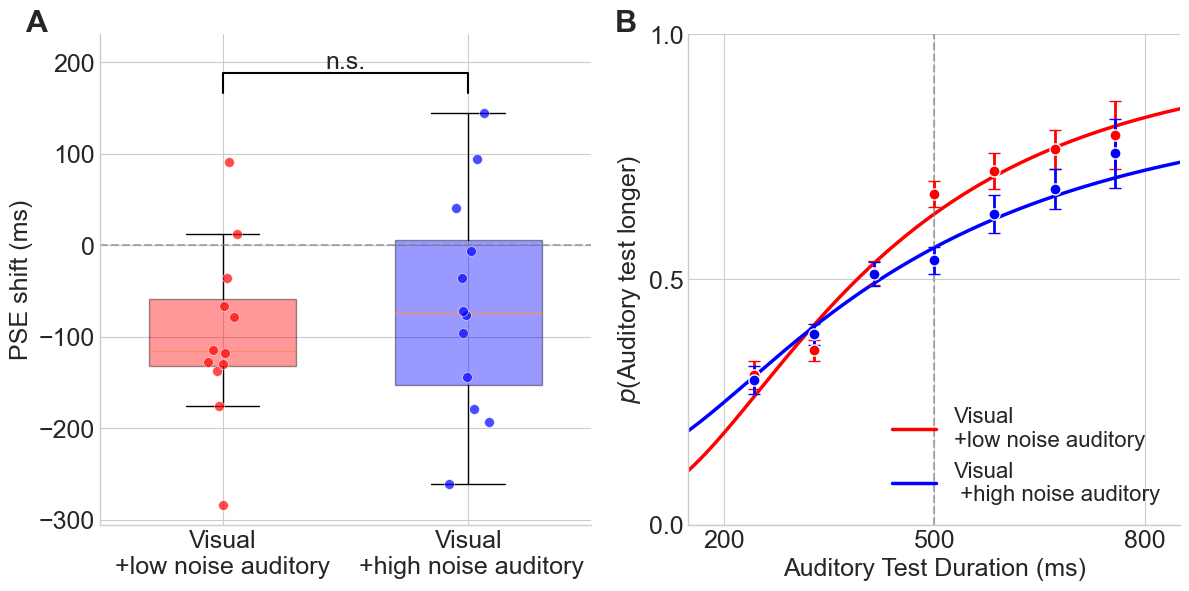

Figure saved as 'psychometric_curves_crossmodal.pdf/.png'

Median PSE shifts: High Rel = -115.9 ms, Low Rel = -73.4 ms
PSE shift comparison: W = 26.0, p = 0.3394

Median PSE: High Rel = 384.1 ms, Low Rel = 426.6 ms
(Positive PSE shift → auditory perceived longer; negative → auditory perceived shorter)


Text(0.5, -0.02, 'Figure: Psychometric curves and PSE shifts for cross-modal duration comparisons.\nLeft (A): Box plots of point of subjective equality (PSE) shifts comparing high SNR (0.1, red) and low SNR (1.2, blue) conditions. Individual participant data shown as scatter points. PSE shift represents the difference between perceived and standard duration (500 ms). Wilcoxon test: W = 26.0, p = 0.339 (n.s.).\nRight (B): Psychometric curves fitted with lognormal cumulative distribution functions (λ, μ, σ parameters from pooled fits) overlaid with binned proportion data (7 bins, 0.2–0.8 s range, error bars = SEM). Higher proportions indicate stronger tendency to perceive auditory stimulus as longer than visual standard.')

In [21]:
from scipy import stats
import numpy as np
from scipy.stats import wilcoxon

# ============================================================================
# PSYCHOMETRIC CURVES + PSE BOX PLOTS: CROSS-MODAL
# ============================================================================

import matplotlib.pyplot as plt

STANDARD_DURATION = 500  # ms
STANDARD_DURATION_S = 0.5
FONT_SIZE = 18

def psychometric_lognormal_plot(test_dur, standard_dur, lambda_, mu, sigma):
    log_ratio = np.log(test_dur / standard_dur)
    z = (log_ratio - mu) / sigma
    return lambda_/2 + (1 - lambda_) * stats.norm.cdf(z)

# Cross-modal parameters from pooled fit
lambda_cm = [params_cm_high[0], params_cm_low[0]]
mu_cm     = [params_cm_high[1], params_cm_low[1]]
sigma_cm  = [params_cm_high[2], params_cm_low[2]]

condition_names_cm = ['Cross-modal high SNR', 'Cross-modal low SNR']
colors_cm = ['red', 'blue']

# Binning function
def bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8)):
    df_filtered = df[(df['testDurS'] >= dur_range[0]) & (df['testDurS'] <= dur_range[1])]
    bins = np.linspace(dur_range[0], dur_range[1], n_bins + 1)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    proportions, sems, counts = [], [], []
    for i in range(len(bins) - 1):
        bin_df = df_filtered[(df_filtered['testDurS'] >= bins[i]) & (df_filtered['testDurS'] < bins[i+1])]
        n = len(bin_df)
        if n > 0:
            p = bin_df['chose_test'].mean()
            sem = np.sqrt(p * (1 - p) / n) if n > 1 else 0
        else:
            p, sem = np.nan, np.nan
        proportions.append(p); sems.append(sem); counts.append(n)
    return bin_centers, np.array(proportions), np.array(sems), np.array(counts)

# Prepare data
cm_plot = pd.read_csv("data/all_crossModal.csv")
cm_plot = cm_plot[(cm_plot['audNoise'] != 0) & (cm_plot['standardDur'] != 0)]
cm_plot['chose_test'] = (cm_plot['responses'] == cm_plot['order']).astype(int)
cm_plot['testDurS'] = cm_plot['standardDur'] * (1 + cm_plot['delta_dur_percents'])

cm_hi_plot = cm_plot[cm_plot['audNoise'] == 0.1]
cm_lo_plot = cm_plot[cm_plot['audNoise'] == 1.2]
#['Visual\n+high SNR audio', 'Visual\n +low SNR audio']
datasets_cm = [(cm_hi_plot, 'Visual\n+low noise auditory'), (cm_lo_plot, 'Visual\n +high noise auditory')]
test_dur_fine_s = np.linspace(0.05, 1.0, 500)
test_dur_fine_ms = test_dur_fine_s * 1000

# ============================================================================
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# LEFT: Box plots of PSE shift
data_for_box = [pse_shift_cm_high, pse_shift_cm_low]
labels_box = ['Visual\n+low noise auditory', 'Visual\n +high noise auditory']
colors_box = ['red', 'blue']

bp = ax1.boxplot(data_for_box, labels=labels_box, patch_artist=True, widths=0.6, showfliers=False)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.4)

for i, (data, color) in enumerate(zip(data_for_box, colors_box)):
    x = np.random.normal(i+1, 0.04, size=len(data))
    ax1.scatter(x, data, alpha=0.7, color=color, edgecolor='white', s=50, zorder=5, linewidth=0.5)

ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.6, linewidth=1.5)
ax1.set_ylabel('PSE shift (ms)', fontsize=FONT_SIZE)
ax1.tick_params(labelsize=FONT_SIZE)

# Significance bracket for PSE shift comparison
stat_pse, p_pse_shift = wilcoxon(pse_shift_cm_high, pse_shift_cm_low, alternative='two-sided')
y_max = np.max([np.max(d) for d in data_for_box])
y_min = np.min([np.min(d) for d in data_for_box])
bracket_gap = (y_max - y_min) * 0.05
sig_mark = '**' if p_pse_shift < 0.01 else ('*' if p_pse_shift < 0.05 else 'n.s.')
h = bracket_gap
ax1.plot([1, 1, 2, 2], [y_max+h, y_max+2*h, y_max+2*h, y_max+h], 'k-', linewidth=1.5)
ax1.text(1.5, y_max+2*h, sig_mark, fontsize=FONT_SIZE, ha='center', va='bottom')
ax1.set_ylim(bottom=y_min - bracket_gap, top=y_max + bracket_gap * 4)

ax1.text(-0.15, 1.05, 'A', transform=ax1.transAxes, fontsize=FONT_SIZE+4, fontweight='bold', va='top')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# RIGHT: Psychometric curves
for i, ((df, label), lam, mu, sigma, color) in enumerate(zip(datasets_cm, lambda_cm, mu_cm, sigma_cm, colors_cm)):
    p = psychometric_lognormal_plot(test_dur_fine_s, STANDARD_DURATION_S, lam, mu, sigma)
    ax2.plot(test_dur_fine_ms, p, color=color, linewidth=2.5, label=label)
    
    bin_centers, proportions, sems, counts = bin_data_by_test_dur(df, n_bins=7, dur_range=(0.2, 0.8))
    ax2.errorbar(bin_centers*1000, proportions, yerr=sems,
                fmt='o', color=color, markersize=8, capsize=4, capthick=2,
                markeredgecolor='white', markeredgewidth=1, linewidth=0, elinewidth=2, zorder=10)

ax2.axvline(x=STANDARD_DURATION, color='gray', linestyle='--', alpha=0.6, linewidth=1.5)
ax2.set_xlabel('Auditory Test Duration (ms)', fontsize=FONT_SIZE)
ax2.set_ylabel(r'$p$(Auditory test longer)', fontsize=FONT_SIZE)
ax2.legend(loc='lower right', fontsize=FONT_SIZE-2, frameon=False)
ax2.set_xlim([150, 850])
ax2.set_ylim([0, 1])
ax2.set_yticks([0, 0.5, 1.0])
ax2.tick_params(labelsize=FONT_SIZE)

ax2.text(-0.15, 1.05, 'B', transform=ax2.transAxes, fontsize=FONT_SIZE+4, fontweight='bold', va='top')
ax2.set_xticks([200, 500, 800])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('psychometric_curves_crossmodal.pdf', dpi=300, bbox_inches='tight')
plt.savefig('psychometric_curves_crossmodal.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as 'psychometric_curves_crossmodal.pdf/.png'")
print(f"\nMedian PSE shifts: High Rel = {np.median(pse_shift_cm_high):+.1f} ms, Low Rel = {np.median(pse_shift_cm_low):+.1f} ms")
print(f"PSE shift comparison: W = {stat_pse:.1f}, p = {p_pse_shift:.4f}")
print(f"\nMedian PSE: High Rel = {np.median(pse_cm_high):.1f} ms, Low Rel = {np.median(pse_cm_low):.1f} ms")
print(f"(Positive PSE shift → auditory perceived longer; negative → auditory perceived shorter)")

# Add caption for the figure
fig.text(0.5, -0.02, 
         'Figure: Psychometric curves and PSE shifts for cross-modal duration comparisons.\n' +
         'Left (A): Box plots of point of subjective equality (PSE) shifts comparing high SNR (0.1, red) and low SNR (1.2, blue) conditions. ' +
         'Individual participant data shown as scatter points. PSE shift represents the difference between perceived and standard duration (500 ms). ' +
         'Wilcoxon test: W = 26.0, p = 0.339 (n.s.).\n' +
         'Right (B): Psychometric curves fitted with lognormal cumulative distribution functions (λ, μ, σ parameters from pooled fits) overlaid with binned proportion data ' +
         '(7 bins, 0.2–0.8 s range, error bars = SEM). Higher proportions indicate stronger tendency to perceive auditory stimulus as longer than visual standard.',
         ha='center', fontsize=10, style='italic', wrap=True)

In [ ]:
from scipy.stats import wilcoxon

# ============================================================================
# TEST PSE BIAS vs 0 (no cross-modal bias) in each condition
# ============================================================================


print("="*80)
print("PSE BIAS ANALYSIS: Testing whether PSE shift differs from 0")
print("="*80)
print(f"Visual standard = {STANDARD_DURATION} ms")
print(f"N = {n_participants} participants")
print()

# Test for each condition
conditions_pse = [
    ("Cross-modal High Rel (0.1)", pse_shift_cm_high),
    ("Cross-modal Low Rel (1.2)",  pse_shift_cm_low)
]

for cond_name, pse_shift in conditions_pse:
    print(f"{cond_name}:")
    print("-"*70)
    
    # Descriptive statistics
    median_shift = np.median(pse_shift)
    mean_shift = np.mean(pse_shift)
    iqr_25 = np.percentile(pse_shift, 25)
    iqr_75 = np.percentile(pse_shift, 75)
    
    print(f"  PSE shift: median = {median_shift:+.1f} ms, mean = {mean_shift:+.1f} ms")
    print(f"             IQR = {iqr_25:+.1f} to {iqr_75:+.1f} ms")
    
    # Wilcoxon signed-rank test against 0
    try:
        stat, p_value = wilcoxon(pse_shift, alternative='two-sided')
        
        print(f"  Wilcoxon signed-rank test (H₀: PSE shift = 0):")
        print(f"    W = {stat:.1f}, p = {p_value:.4f}")
        
        if p_value < 0.05:
            direction = "LONGER" if median_shift > 0 else "SHORTER"
            print(f"    → Significant bias: Auditory perceived {direction} than visual **")
        else:
            print(f"    → No significant cross-modal bias (n.s.)")
            
    except Exception as e:
        print(f"  Could not perform test: {e}")
    
    print()

# Summary
print("="*80)
print("SUMMARY")
print("="*80)
print("Interpretation:")
print("  PSE shift > 0 → Auditory test perceived LONGER than visual standard")
print("                  (shorter auditory duration needed to match 500ms visual)")
print("  PSE shift < 0 → Auditory test perceived SHORTER than visual standard")
print("                  (longer auditory duration needed to match 500ms visual)")
print("  PSE shift = 0 → No cross-modal temporal bias")

## 5. PSE (Bias) Analysis: Cross-Modal Temporal Distortion

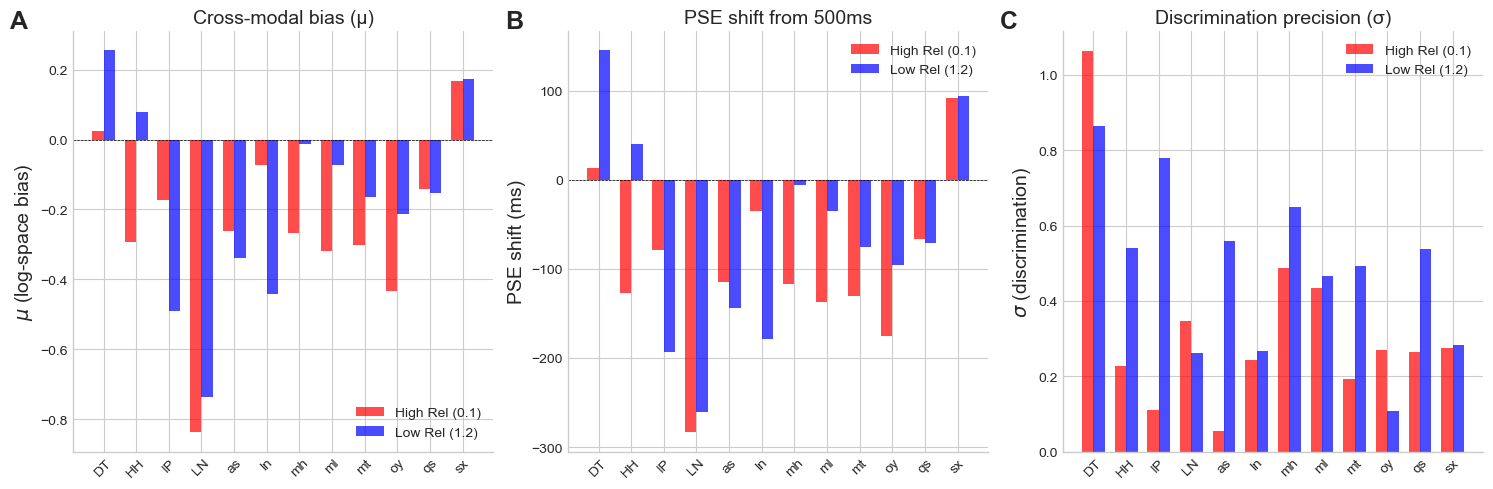


Summary:
  μ > 0 means auditory perceived LONGER than visual (PSE < 500ms)
  μ < 0 means auditory perceived SHORTER than visual (PSE > 500ms)

  High Rel: median μ = -0.2638, median PSE = 384.1 ms
  Low Rel:  median μ = -0.1588, median PSE = 426.6 ms


In [12]:
# ============================================================================
# PSE ANALYSIS: Cross-modal temporal bias
# ============================================================================
# In the cross-modal task, μ captures the systematic difference between
# perceived auditory and visual durations.
#   μ > 0 → Auditory perceived as LONGER than visual → PSE < 500ms
#          (shorter auditory test matches the 500ms visual standard)
#   μ < 0 → Auditory perceived as SHORTER than visual → PSE > 500ms
#          (longer auditory test needed to match 500ms visual standard)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Panel A: μ values per participant
ax = axes[0]
x_positions = np.arange(n_participants)
width = 0.35
ax.bar(x_positions - width/2, mu_cm_high, width, label='High Rel (0.1)', color='red', alpha=0.7)
ax.bar(x_positions + width/2, mu_cm_low, width, label='Low Rel (1.2)', color='blue', alpha=0.7)
ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax.set_xticks(x_positions)
ax.set_xticklabels(valid_participants, rotation=45)
ax.set_ylabel(r'$\mu$ (log-space bias)', fontsize=14)
ax.set_title('Cross-modal bias (μ)', fontsize=14)
ax.legend(fontsize=10)
ax.text(-0.15, 1.05, 'A', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel B: PSE shift in ms
ax = axes[1]
ax.bar(x_positions - width/2, pse_shift_cm_high, width, label='High Rel (0.1)', color='red', alpha=0.7)
ax.bar(x_positions + width/2, pse_shift_cm_low, width, label='Low Rel (1.2)', color='blue', alpha=0.7)
ax.axhline(y=0, color='k', linewidth=0.5, linestyle='--')
ax.set_xticks(x_positions)
ax.set_xticklabels(valid_participants, rotation=45)
ax.set_ylabel('PSE shift (ms)', fontsize=14)
ax.set_title('PSE shift from 500ms', fontsize=14)
ax.legend(fontsize=10)
ax.text(-0.15, 1.05, 'B', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top')

# Panel C: σ comparison
ax = axes[2]
ax.bar(x_positions - width/2, sigma_cm_high, width, label='High Rel (0.1)', color='red', alpha=0.7)
ax.bar(x_positions + width/2, sigma_cm_low, width, label='Low Rel (1.2)', color='blue', alpha=0.7)
ax.set_xticks(x_positions)
ax.set_xticklabels(valid_participants, rotation=45)
ax.set_ylabel(r'$\sigma$ (discrimination)', fontsize=14)
ax.set_title('Discrimination precision (σ)', fontsize=14)
ax.legend(fontsize=10)
ax.text(-0.15, 1.05, 'C', transform=ax.transAxes, fontsize=18, fontweight='bold', va='top')

for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('crossmodal_bias_analysis.pdf', dpi=300, bbox_inches='tight')
plt.savefig('crossmodal_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSummary:")
print(f"  μ > 0 means auditory perceived LONGER than visual (PSE < 500ms)")
print(f"  μ < 0 means auditory perceived SHORTER than visual (PSE > 500ms)")
print(f"\n  High Rel: median μ = {np.median(mu_cm_high):.4f}, median PSE = {np.median(pse_cm_high):.1f} ms")
print(f"  Low Rel:  median μ = {np.median(mu_cm_low):.4f}, median PSE = {np.median(pse_cm_low):.1f} ms")

## 6. Summary Table

In [13]:
# ============================================================================
# COMPREHENSIVE SUMMARY TABLE
# ============================================================================

print("CROSS-MODAL DURATION DISCRIMINATION: SUMMARY")
print("="*80)
print(f"Task: Visual standard (500ms) vs Auditory test")
print(f"Model: P(choose aud test) = λ/2 + (1-λ) Φ((log(T_test/T_std) - μ) / σ)")
print(f"μ is FREE (captures cross-modal temporal bias)")
print(f"N = {n_participants} participants")
print()

summary = pd.DataFrame({
    'Condition': ['Cross-modal High Rel', 'Cross-modal Low Rel'],
    'Median σ': [np.median(sigma_cm_high), np.median(sigma_cm_low)],
    'IQR σ': [f"{np.percentile(sigma_cm_high,25):.3f}–{np.percentile(sigma_cm_high,75):.3f}",
              f"{np.percentile(sigma_cm_low,25):.3f}–{np.percentile(sigma_cm_low,75):.3f}"],
    'Median μ': [np.median(mu_cm_high), np.median(mu_cm_low)],
    'Median WF': [np.median(weber_cm_high), np.median(weber_cm_low)],
    'Median JND (ms)': [np.median(jnd_cm_high), np.median(jnd_cm_low)],
    'Median PSE (ms)': [np.median(pse_cm_high), np.median(pse_cm_low)],
    'PSE shift (ms)': [np.median(pse_shift_cm_high), np.median(pse_shift_cm_low)],
})
print(summary.to_string(index=False, float_format='%.4f'))

print("\n" + "="*80)
print("STATISTICAL TESTS")
print("="*80)
print(f"σ (High vs Low Rel): W = {stat_sig:.1f}, p = {p_sig:.4f}")
print(f"μ (High vs Low Rel): W = {stat_mu:.1f}, p = {p_mu:.4f}")

print("\n" + "="*80)
print("KEY INTERPRETATION NOTES")
print("="*80)
print("""  
1. In the cross-modal task, μ MUST be free because the PSE reflects
   systematic differences in perceived auditory vs visual duration.

2. The same log-normal conversion formulas apply:
   - PSE = T_std × exp(μ) 
   - JND = T_std × exp(μ) × (exp(0.6745σ) − 1)
   - Weber = √(exp(σ²) − 1)  [depends only on σ]

3. No special μ conversion is needed between unimodal and cross-modal.
   The μ parameter has the same mathematical meaning in both cases:
   it's the log-ratio bias. The INTERPRETATION differs:
   - Unimodal: μ ≈ 0 (no systematic within-modality bias)
   - Cross-modal: μ ≠ 0 reflects auditory-visual temporal distortion

4. Positive μ → auditory perceived as longer than visual
   Negative μ → auditory perceived as shorter than visual
""")

CROSS-MODAL DURATION DISCRIMINATION: SUMMARY
Task: Visual standard (500ms) vs Auditory test
Model: P(choose aud test) = λ/2 + (1-λ) Φ((log(T_test/T_std) - μ) / σ)
μ is FREE (captures cross-modal temporal bias)
N = 12 participants

           Condition  Median σ       IQR σ  Median μ  Median WF  Median JND (ms)  Median PSE (ms)  PSE shift (ms)
Cross-modal High Rel    0.2670 0.218–0.368   -0.2638     0.2718          73.6372         384.0816       -115.9184
 Cross-modal Low Rel    0.5154 0.279–0.581   -0.1588     0.5519         169.5586         426.5773        -73.4227

STATISTICAL TESTS
σ (High vs Low Rel): W = 16.0, p = 0.0771
μ (High vs Low Rel): W = 26.0, p = 0.3394

KEY INTERPRETATION NOTES
  
1. In the cross-modal task, μ MUST be free because the PSE reflects
   systematic differences in perceived auditory vs visual duration.

2. The same log-normal conversion formulas apply:
   - PSE = T_std × exp(μ) 
   - JND = T_std × exp(μ) × (exp(0.6745σ) − 1)
   - Weber = √(exp(σ²) − 1)  [depe